In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
#import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

# A: whole RBS sequence (len: 29)
# B: extracted 20-base RBS seqeunce (A[7:27], len: 20), training features
# C: TIR labels
# D: the design part RBS (B[7:13], len: 6) 

Path = '../../data/Baseline_data/RBS_seqs.csv'

df = pd.read_csv(Path)
df.columns = ['A', 'B', 'C']
df['D'] = df['B'].str[7:13]
df.head()

,A,B,C,D
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,TTAAGTAAGCGGGGAAAATA,57706,AGCGGG
1,ACGATCTTAAGTAGACGCGGAAAATAATG,TTAAGTAGACGCGGAAAATA,613,GACGCG
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,TTAAGTAAGCGCGGAAAATA,5313,AGCGCG
3,ACGATCTTAAGTAAACGAGGAAAATAATG,TTAAGTAAACGAGGAAAATA,19594,AACGAG
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,TTAAGTAGGCGAGGAAAATA,33626,GGCGAG


In [3]:
df = df.drop_duplicates(subset = ['B', 'C'])
df.shape

(113, 4)

In [4]:
Log_flag = False # indicates whether take log label
Norm_method = 'mean' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization 
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [5]:
data6 = np.asarray(normalize(df)[['D', 'C']])
data6.shape

(113, 2)

In [6]:
data = np.asarray(normalize(df)[['B', 'C']])
data.shape

(113, 2)

In [7]:
Path = '../../data/firstRound_4h_normTrue_formatSeq.csv'

df_FRR = pd.read_csv(Path)
df_FRR = df_FRR[df_FRR['Group'] == 'bandit']
df_FRR = df_FRR[['RBS', 'AVERAGE', 'STD']]
df_FRR['label'] = df_FRR['AVERAGE']
df_FRR

,RBS,AVERAGE,STD,label
89,TTTAAGACGGATTTATACAT,1.003498,0.164660,1.003498
90,TTTAAGACTCGGATATACAT,0.184299,0.308294,0.184299
91,TTTAAGAACCGGATATACAT,0.054527,0.151270,0.054527
92,TTTAAGAATCGGATATACAT,-0.026178,0.084218,-0.026178
93,TTTAAGACCGGATTATACAT,-0.202923,0.118594,-0.202923
94,TTTAAGACGATAATATACAT,-0.263058,0.189485,-0.263058
95,TTTAAGAACACACTATACAT,-0.359530,0.130507,-0.359530
96,TTTAAGATATATATATACAT,-0.331725,0.231149,-0.331725
97,TTTAAGACTCTCTTATACAT,0.008679,0.357741,0.008679
98,TTTAAGAATATATTATACAT,-0.011931,0.159450,-0.011931


In [8]:
df[['RBS', 'AVERAGE']] = df[['B', 'C']]
df['STD'] = np.std(df['C'])
df['label'] = df['AVERAGE']
df_baseline_FFR = df[['RBS', 'AVERAGE', 'STD', 'label']].append(df_FRR)
df_baseline_FFR = df_baseline_FFR.reset_index()

In [9]:
test_idx = np.asarray(range(113,150))
train_idx = np.asarray(range(113))

{'alpha': 0.1, 'copy_X_train': True, 'kernel__l_list': [6], 'kernel__weight_flag': False, 'kernel__padding_flag': False, 'kernel__gap_flag': False, 'kernel__sigma_0': 1e-10, 'kernel__sigma_0_bounds': (1e-10, 10000000000.0), 'kernel': WeightedDegree_Kernel(sigma_0=1e-10), 'n_restarts_optimizer': 0, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}
Train:  0.46618128409792753
Test:  1.0516389875972614


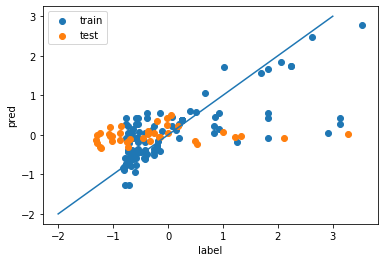

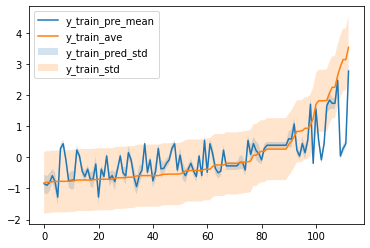

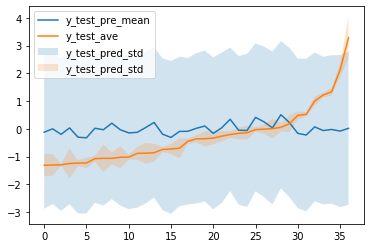

In [10]:
train_df, test_df = regression(df_baseline_FFR, train_idx = train_idx, test_idx = test_idx, kernel_name='WD_Kernel',alpha=0.1, embedding='label',
                   eva_metric=mean_squared_error, eva_on_ave_flag=True, l_list=[6], b=0.1, 
                   weight_flag=False, padding_flag=False, gap_flag=False)

In [11]:
train_df

,index,RBS,AVERAGE,STD,label,prediction
0,0,TTAAGTAAGCGGGGAAAATA,2.063818,0.995565,2.063818,1.836779
1,1,TTAAGTAGACGCGGAAAATA,-0.801225,0.995565,-0.801225,-0.898862
2,2,TTAAGTAAGCGCGGAAAATA,-0.565370,0.995565,-0.565370,-0.371085
3,3,TTAAGTAAACGAGGAAAATA,0.151280,0.995565,0.151280,0.118398
4,4,TTAAGTAGGCGAGGAAAATA,0.855435,0.995565,0.855435,0.439783
5,5,TTAAGTAGGCGCGGAAAATA,-0.676623,0.995565,-0.676623,-0.780624
6,6,TTAAGTAAACGGGGAAAATA,-0.176158,0.995565,-0.176158,-0.161622
7,7,TTAAGTAAACGCGGAAAATA,-0.756362,0.995565,-0.756362,-0.729230
8,8,TTAAGTAGACGAGGAAAATA,-0.498126,0.995565,-0.498126,-0.436065
9,9,TTAAGTAGGCGGGGAAAATA,0.066673,0.995565,0.066673,0.213372


In [12]:
test_df

,index,RBS,AVERAGE,STD,label,prediction
113,89,TTTAAGACGGATTTATACAT,1.003498,0.164660,1.003498,0.071741
114,90,TTTAAGACTCGGATATACAT,0.184299,0.308294,0.184299,0.229300
115,91,TTTAAGAACCGGATATACAT,0.054527,0.151270,0.054527,0.510504
116,92,TTTAAGAATCGGATATACAT,-0.026178,0.084218,-0.026178,0.413750
117,93,TTTAAGACCGGATTATACAT,-0.202923,0.118594,-0.202923,0.345371
118,94,TTTAAGACGATAATATACAT,-0.263058,0.189485,-0.263058,0.037622
119,95,TTTAAGAACACACTATACAT,-0.359530,0.130507,-0.359530,0.020895
120,96,TTTAAGATATATATATACAT,-0.331725,0.231149,-0.331725,-0.160813
121,97,TTTAAGACTCTCTTATACAT,0.008679,0.357741,0.008679,0.036020
122,98,TTTAAGAATATATTATACAT,-0.011931,0.159450,-0.011931,0.253442
